In [73]:
%matplotlib inline

import dill

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
import random
from sklearn.neural_network import MLPClassifier

In [2]:
dill.load_session('nearest_neighbor.db')

In [3]:
# constants
n_train = 10000
n_test = 2000
top_k = 10
n_predict = 20

In [4]:
# load features
features_train_ff = pd.read_csv('data/features_train/features_resnet1000_train.csv', delimiter=',', index_col=0, header=None)
features_test_ff = pd.read_csv('data/features_test/features_resnet1000_test.csv', delimiter=',', index_col=0, header=None)

features_train_ff.index = features_train_ff.index.str.lstrip('images_train/').str.rstrip('.jpg')
features_train_ff.index = pd.to_numeric(features_train_ff.index, errors='coerce')
features_train_ff.sort_index(inplace=True)

features_test_ff.index = features_test_ff.index.str.lstrip('images_test/').str.rstrip('.jpg')
features_test_ff.index = pd.to_numeric(features_test_ff.index, errors='coerce')
features_test_ff.sort_index(inplace=True)

In [5]:
# word preprocessing
import re
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import stopwords

class Preprocess(object):
    def __init__(self):
        self.stemmer = EnglishStemmer()
        # self.stopList = set(stopwords.words("english"))
        self.stopList = set([word.encode('ascii', 'ignore') for word in stopwords.words('english')])
        
    def preprocess(self, string, n_gram=1):
        
        # replace special character with space
        string = re.sub(r'[^a-zA-Z0-9 ]', r' ', string).encode('ascii', 'ignore')
        
        # Lemmatization (handles capitalization), ignoring stop word
        # turn output to ASCII and ignore special character
        ans = [self.stemmer.stem(word).encode('ascii', 'ignore') for word in string.split()]
        ans = [word for word in ans if word not in self.stopList]
        
        return ans

In [6]:
# load descriptions
descriptions_train = [set()] * n_train
processor = Preprocess()
for i in range(n_train):
    with open('data/descriptions_train/' + str(i) + '.txt') as f:
        words = f.read() # readlines()
        descriptions_train[i] = processor.preprocess(words)

descriptions_test = [set()] * n_test
for i in range(n_test):
    with open('data/descriptions_test/' + str(i) + '.txt') as f:
        words = f.read() # readlines()
        descriptions_test[i] = processor.preprocess(words)

In [7]:
# get bag of words features
def BagofWords(train, test):
    bag = set()
    for words in train:
        bag |= set(words)
    bag = list(bag)
    bag_idx = {x:i for i, x in enumerate(bag)}
    print(len(bag))
    # print(bag)
    
    # create feature vectors
    train_features = np.zeros((len(train), len(bag)))
    test_features = np.zeros((len(test), len(bag)))

    data = [train, test]
    features = [train_features, test_features]
    # '''
    for k in [0,1]:
        print('train/test: ', k)
        for i in xrange(len(data[k])):
            # if i%500 == 0: print(k, i)
            for word in data[k][i]:
                try:
                    features[k][i, bag_idx[word] ] += 1
                except KeyError: pass
    # '''
    return train_features, test_features, bag, bag_idx

train_features, test_features, bag, bag_idx = BagofWords(descriptions_train, descriptions_test)

6409
('train/test: ', 0)
('train/test: ', 1)


In [8]:
# post-process: L2 normalization
from sklearn.preprocessing import normalize
train_features = normalize(train_features, norm='l2', axis=1)
test_features = normalize(test_features, norm='l2', axis=1)

In [68]:
#Positive Examples
pos = [0 for i in range(10000)]
for i in range(10000):
    pos[i] = np.concatenate((features_train_ff.values[i],train_features[i]))

In [72]:
#Negative Examples
neg = [0 for i in range(10000)]
for i in range(10000):
    j = random.randint(0,10000-1)
    while j == i:
        j = random.randint(0,10000-1)
    neg[i] = np.concatenate((features_train_ff.values[i],train_features[j]))

In [76]:
#Lables for Neural Network
y_1 = np.ones(10000)
y_0 = np.zeros(10000)
y = np.concatenate((y_1,y_0))
print(y.shape)

(20000,)


In [77]:
#X data for Neural Network
X = np.concatenate((pos,neg))

In [78]:
clf = MLPClassifier(solver='adam', hidden_layer_sizes=(100,100), max_iter = 100, random_state=1)

In [79]:
clf.fit(X,y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [99]:
ans = clf.predict_proba([np.concatenate((features_test_ff.values[0], test_features[1])) ] )

In [103]:
ans[0, 1]

0.5547387666164015

In [ ]:
ans  = [[0 for i in range(2000)] for j in range(2000)]
for i in range(2000):
    for j in range(2000):
        ans[i][j] = clf.predict_proba([np.concatenate((features_test_ff.values[i], test_features[j])) ] )[0, 1]   

In [1]:
test_vector = []
for i in range(2000):
    for j in range(2000):
        test_vector.append(np.concatenate((features_test_ff.values[i], test_features[j])))

NameError: name 'np' is not defined

In [9]:
def kNN_prediction(train_index_img, test_index_img, train_index_caption, test_index_caption, dist_caption, dist_image, w_caption=2933, w_img=1):
    assert(len(features_train_ff) == len(train_features))
    assert(len(features_test_ff) == len(test_features))
    
    n_train = len(train_index_img)
    n_test = len(test_index_img)
    
    # find closest caption in train 
    # dist_caption = cdist(test_features, train_features, metric='sqeuclidean')
    closest_caption_idx = np.argpartition(dist_caption, top_k, axis=1)[:, :top_k]
    closest_caption_dist = np.asarray([dist_caption[i, closest_caption_idx[i]] for i in range(len(dist_caption))])
    
    # find closest image in test
    # dist_image = cdist(features_train_ff, features_test_ff, metric='sqeuclidean')
    closest_image_idx = np.argpartition(dist_image, top_k, axis=1)[:, :top_k]
    closest_image_dist = np.asarray([dist_image[i, closest_image_idx[i]] for i in range(len(dist_image))])
    
    # get 400 distances (dist_caption+dist_image) for each caption
    dist_final = np.empty((n_test, top_k*top_k))
    idx_final = np.empty((n_test, top_k*top_k))
    for i in range(n_test):
        for j in range(top_k):
            d_caption = closest_caption_dist[i, j]
            for k in range(top_k):
                d_img = closest_image_dist[closest_caption_idx[i, j], k]
                dist_final[i, j*top_k+k] = d_caption * w_caption + d_img * w_img
                idx_final[i, j*top_k+k] = closest_image_idx[closest_caption_idx[i, j], k] # need to fix
    
    # reassign the labels
    # print(test_index_img[3], inx_fina[i, j])
    '''
    for i in range(len(idx_final)):
        for j in range(len(idx_final[0])):
            idx_final[i, j] = test_index_img[int(idx_final[i, j])]
    '''

    # predict
    dist_final_arg = np.argsort(dist_final, axis=1)
    predict = [[] for _ in range(n_test)]
    for i in range(n_test):
        for j in range(top_k*top_k):
            if len(predict[i]) != n_predict and idx_final[i, dist_final_arg[i, j]] not in predict[i]:
                # print(idx_final[i, dist_final_arg[i, j]])
                predict[i].append(idx_final[i, dist_final_arg[i, j]])
                
    for i in range(len(predict)):
        for j in range(len(predict[0])):
            predict[i][j] = test_index_img[int(predict[i][j])]
    
    return predict

In [10]:
def scoring(predict, label):
    print(len(predict), len(label))
    assert(len(predict) == len(label))
    score = 0
    for i in range(len(predict)):
        try:
            idx = predict[i].index(label[i])
            score += (21 - idx) / 20
        except ValueError:
            print(label[i], predict[i])
            pass
    score /= len(predict)
    print(score)
    return score

In [11]:
# precomputation
from sklearn.model_selection import KFold
n_splits = 3
kf = KFold(n_splits=n_splits)

train_index_img = [train_index for train_index, test_index in kf.split(features_train_ff)]
test_index_img = [test_index for train_index, test_index in kf.split(features_train_ff)]
train_index_caption = [train_index for train_index, test_index in kf.split(train_features)]
test_index_caption = [test_index for train_index, test_index in kf.split(train_features)]

# precompute the distances
dist_caption, dist_image = [], []
for i in range(n_splits):
    dist_caption.append( cdist(train_features[test_index_caption[i]], train_features[train_index_caption[i]], metric='sqeuclidean') )
    dist_image.append( cdist(features_train_ff.values[train_index_img[i]], features_train_ff.values[test_index_img[i]], metric='sqeuclidean') )


In [12]:
dist_caption[0].shape

(3334, 6666)

(3334, 3334)
(0, [1472, 1121, 2432, 370, 4, 269, 1481, 2962, 2439, 1271, 1295, 2440, 2343, 2341, 1957, 1306, 1154, 805, 308, 1317])
(1, [2186, 1446, 2086, 2828, 1764, 1023, 609, 186, 563, 3274, 1045, 1326, 2024, 375, 1221, 2443, 1899, 1919, 2870, 2733])
(2, [1584, 2717, 2758, 1382, 1524, 2729, 1807, 2292, 531, 447, 127, 278, 529, 928, 2638, 808, 2120, 2269, 729, 1869])
(4, [1902, 3212, 1621, 3211, 1590, 2430, 1532, 34, 605, 535, 2997, 3162, 448, 1317, 402, 1120, 1656, 1567, 2433, 1464])
(6, [584, 1083, 1419, 2167, 1450, 2528, 3203, 1347, 785, 917, 1689, 1892, 927, 1875, 2798, 2498, 2424, 1644, 1045, 991])
(7, [2789, 2736, 1723, 2168, 1432, 2400, 1285, 271, 50, 1818, 3145, 1564, 412, 385, 2451, 2478, 2908, 2807, 1875, 991])
(8, [16, 2886, 2860, 1904, 2407, 1305, 2223, 2317, 24, 323, 2656, 2344, 1018, 2985, 3087, 2115, 3160, 2197, 2484, 2035])
(9, [2427, 2420, 265, 257, 239, 956, 237, 652, 153, 446, 552, 1345, 2588, 2935, 380, 405, 2695, 1307, 1088, 510])
(10, [795, 1361, 2664, 2082, 106

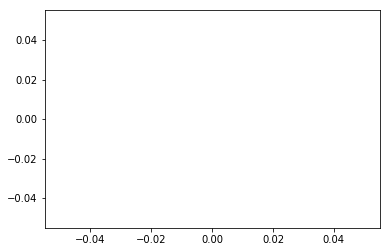

In [13]:
# do 3 fold cross validation
w_captions = [1500]# , 2000, 2500, 3000, 3500] # modify this line
accuracy = np.empty(len(w_captions))

for i, w_caption in enumerate(w_captions):
    for j in range(1):
        cv_predict = kNN_prediction(train_index_img[j],
                                    test_index_img[j],
                                    train_index_caption[j],
                                    test_index_caption[j],
                                    dist_caption[j],
                                    dist_image[j],
                                    w_caption=w_caption)
        
        accuracy[i] += scoring(cv_predict, test_index_caption[j])
accuracy /= n_splits
plt.plot(accuracy)

In [14]:
cv_predict[0]
test_index_caption[2]

array([6667, 6668, 6669, ..., 9997, 9998, 9999])

In [15]:
A = np.asarray([[1, 2], [3, 0]])
I = np.asarray([11, 22, 33, 44])
for i in range(len(A)):
    for j in range(len(A[0])):
        A[i, j] = I[A[i, j]]
# x = np.asarray([[I[x] for L in A] for x in L])
print(A)
x = test_index_img[0]
x[3]

[[22 33]
 [44 11]]


3

In [16]:
print(accuracy)

[0.]


In [17]:
# find closest caption in train
dist_caption = cdist(test_features, train_features, metric='sqeuclidean')
closest_caption_idx = np.argpartition(dist_caption, top_k, axis=1)[:, :top_k]
closest_caption_dist = np.asarray([dist_caption[i, closest_caption_idx[i]] for i in range(len(dist_caption))])

In [18]:
# find closest image in test
dist_image = cdist(features_train_ff.values, features_test_ff.values, metric='sqeuclidean')
closest_image_idx = np.argpartition(dist_image, top_k, axis=1)[:, :top_k]
closest_image_dist = np.asarray([dist_image[i, closest_image_idx[i]] for i in range(len(dist_image))])

In [19]:
# get 400 distances (dist_caption+dist_image) for each caption
dist_final = np.empty((n_test, top_k*top_k))
idx_final = np.empty((n_test, top_k*top_k))
w_caption = 2933 # caption_dist * weight + image_dist
w_img = 1
for i in range(n_test):
    for j in range(top_k):
        d_caption = closest_caption_dist[i, j]
        for k in range(top_k):
            d_img = closest_image_dist[closest_caption_idx[i, j], k]
            dist_final[i, j*top_k+k] = d_caption * w_caption + d_img * w_img
            idx_final[i, j*top_k+k] = closest_image_idx[closest_caption_idx[i, j], k]

In [20]:
# predict
dist_final_arg = np.argsort(dist_final, axis=1)
predict = [[] for _ in range(n_test)]
for i in range(n_test):
    for j in range(top_k*top_k):
        if len(predict[i]) != n_predict and idx_final[i, dist_final_arg[i, j]] not in predict[i]:
            # print(idx_final[i, dist_final_arg[i, j]])
            predict[i].append(idx_final[i, dist_final_arg[i, j]])

In [21]:
# convert prediction to '0.jpg'
test_predict_str = [None] * n_test
for i in range(n_test):
    res = ' '.join([str(int(x)) + '.jpg' for x in predict[i]])
    test_predict_str[i] = res # ' '.join([str(int(x)) + '.jpg' for x in test_predict[i]])

# write to csv
df = pd.DataFrame(data=test_predict_str)
df.index = [str(x) + '.txt' for x in range(n_test)]
df.to_csv('./nearest_neighbor.csv', mode='w', index=True, index_label='Descritpion_ID', header=['Top_20_Image_IDs'])

In [23]:
dill.dump_session('nearest_neighbor.db')

In [24]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)

accuracy_gaussian = 0
clf_gaussian = GaussianNB()
for train_index, test_index in kf.split(train_data):
    clf_gaussian.fit(train_data[train_index], train_label[train_index])
    train_pred = clf_gaussian.predict(train_data[test_index])
    accuracy_gaussian += sum(train_label[test_index] == train_pred)
accuracy_gaussian /= float(num_train)
print accuracy_gaussian

NameError: name 'GaussianNB' is not defined